In [1]:
import pandas as pd

## Carregando os dados

Vamos carregar os dados e inspecionar visualmente.

Podemos aplicar um estilo no dataset que coloca um gradiente colorido na coluna, isso nos ajuda a identificar valores mais extremos de forma rápida.

In [2]:
vendas = pd.read_excel('Aula 03 - Atividade - Base vendas.xlsx')

FileNotFoundError: [Errno 2] No such file or directory: 'Aula 03 - Atividade - Base vendas.xlsx'

In [3]:
vendas.style.background_gradient(cmap='BuPu', subset=['Vendas'])

,Dia,Vendas
0,1,12
1,2,16
2,3,12
3,4,10
4,5,11
5,6,178
6,7,12
7,8,43
8,9,13
9,10,10


## Z-Score

In [4]:
from scipy import stats

In [5]:
zscores = stats.zscore(vendas['Vendas'],ddof=1)

In [6]:
zscores

array([-0.39961159, -0.34116748, -0.39961159, -0.42883364, -0.41422261,
        2.02581888, -0.39961159,  0.05333025, -0.38500056, -0.42883364,
       -0.00511386, -0.41422261, -0.39961159,  0.05333025, -0.38500056,
       -0.39961159, -0.28272337, -0.37038953, -0.42883364,  0.17021846,
       -0.42883364, -0.42883364,  2.78559228, -0.39961159, -0.38500056,
       -0.41422261, -0.31194542, -0.42883364, -0.39961159, -0.39961159,
        2.81481433, -0.19505721, -0.42883364, -0.41422261, -0.42883364,
       -0.2973344 , -0.37038953,  3.80836416, -0.26811234,  0.17021846])

### Aplicando o limite para identificar os outliers

In [7]:
zscores[zscores > 3]

array([3.80836416])

#### Encontrando a posição do outlier identificado

In [8]:
import numpy as np

In [9]:
np.where(zscores > 3)

(array([37]),)

#### Visualizando o outlier encontrado

In [10]:
vendas.loc[[37]]

,Dia,Vendas
37,38,300


### Atenção

Observamos que o Z-Score capturou apenas um outlier: o valor 300, que é o mais extremo. Isso mostra como esse método é sensível à valores extremos.

Se diminuírmos o nosso limite, conseguiremos identificar os outros

In [11]:
vendas.loc[np.where((zscores > 1.96) | (zscores < -1.96))]

,Dia,Vendas
5,6,178
22,23,230
30,31,232
37,38,300


## Cumulative Distribution

In [12]:
stats.norm.cdf(-1.96)

0.024997895148220435

In [13]:
stats.norm.ppf(0.01)

-2.3263478740408408

In [14]:
stats.norm.ppf(0.99)

2.3263478740408408

## Modified Z-Score

In [15]:
def m_zscore(lista):
    mediana = np.median(lista)
    mad = np.median([np.abs(y - mediana) for y in lista])
    
    valores = []
    for valor in lista:
        score = 0.6745 * (valor - mediana) / mad
        valores.append(score)
    
    return valores

### Visualizando os outliers identificados

Na lista abaixo conseguimos visualizar os scores acima / abaixo do limite e o índice deles.

Mais abaixo temos os valores encontrados no dataframe

In [16]:
m_scores = m_zscore(vendas['Vendas'])

In [17]:
[[i, x] for i, x in enumerate(m_scores) if (x > 3) | ( x < -3)]

[[5, 44.6519],
 [7, 8.2289],
 [10, 7.1497],
 [13, 8.2289],
 [19, 10.3873],
 [22, 58.68149999999999],
 [30, 59.2211],
 [31, 3.6423],
 [37, 77.5675],
 [39, 10.3873]]

In [18]:
vendas.loc[[i for i, x in enumerate(m_scores) if (x > 3) | ( x < -3)]]

,Dia,Vendas
5,6,178
7,8,43
10,11,39
13,14,43
19,20,51
22,23,230
30,31,232
31,32,26
37,38,300
39,40,51


### Atenção

Observamos que o Z-Score modificado é, por outro lado, bem menos sensível a valores extremos que o Z-Score "normal" (baseado na média). Ele capturou uma grande quantidade de outliers, alguns que podemos considerar "duvidosos", o que torna esse método bem mais agressivo.

## Média Móvel

In [19]:
vendas[0:7]

,Dia,Vendas
0,1,12
1,2,16
2,3,12
3,4,10
4,5,11
5,6,178
6,7,12


In [20]:
vendas['MM'] = vendas.Vendas.rolling(7,center=False).mean() 
vendas.head(15)

,Dia,Vendas,MM
0,1,12,NaN
1,2,16,NaN
2,3,12,NaN
3,4,10,NaN
4,5,11,NaN
5,6,178,NaN
6,7,12,35.857143
7,8,43,40.285714
8,9,13,39.857143
9,10,10,39.571429


In [21]:
vendas['ResiduoMM'] = abs(vendas.Vendas - vendas.MM)
vendas['ToleranciaMM'] = vendas.MM * 0.5
vendas.head(15)

,Dia,Vendas,MM,ResiduoMM,ToleranciaMM
0,1,12,NaN,NaN,NaN
1,2,16,NaN,NaN,NaN
2,3,12,NaN,NaN,NaN
3,4,10,NaN,NaN,NaN
4,5,11,NaN,NaN,NaN
5,6,178,NaN,NaN,NaN
6,7,12,35.857143,23.857143,17.928571
7,8,43,40.285714,2.714286,20.142857
8,9,13,39.857143,26.857143,19.928571
9,10,10,39.571429,29.571429,19.785714


In [22]:
vendas['OutlierMM'] = (vendas.ResiduoMM > vendas.ToleranciaMM)
vendas.head(15)

,Dia,Vendas,MM,ResiduoMM,ToleranciaMM,OutlierMM
0,1,12,NaN,NaN,NaN,False
1,2,16,NaN,NaN,NaN,False
2,3,12,NaN,NaN,NaN,False
3,4,10,NaN,NaN,NaN,False
4,5,11,NaN,NaN,NaN,False
5,6,178,NaN,NaN,NaN,False
6,7,12,35.857143,23.857143,17.928571,True
7,8,43,40.285714,2.714286,20.142857,False
8,9,13,39.857143,26.857143,19.928571,True
9,10,10,39.571429,29.571429,19.785714,True


### Visualizando o resultado

In [23]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.style.use('seaborn')

[]

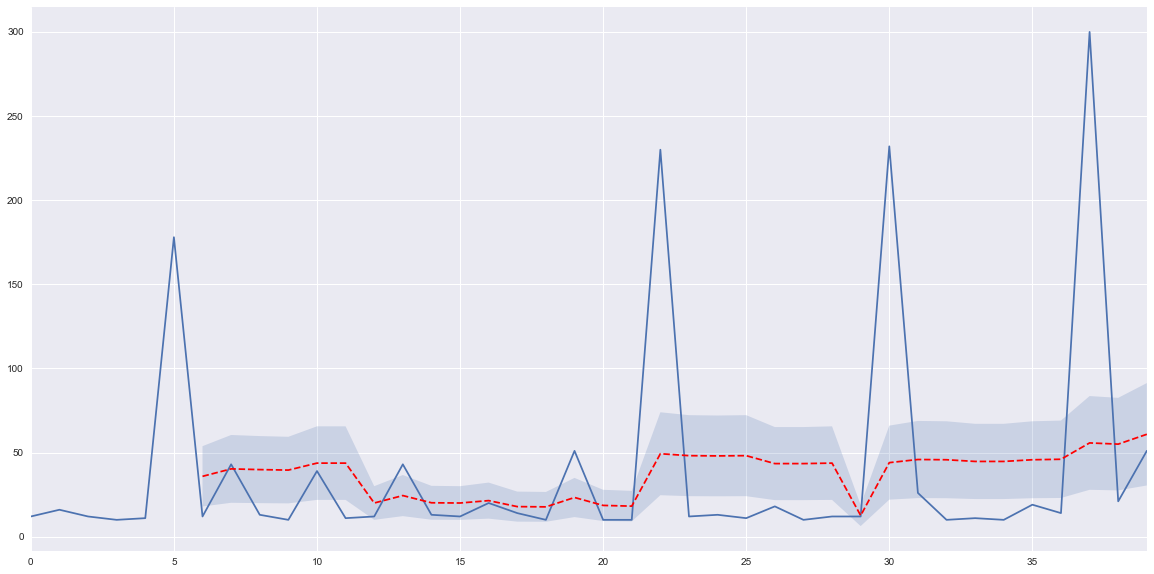

In [24]:
_=vendas.Vendas.plot(figsize=(20, 10))
_=vendas.MM.plot(figsize=(20, 10), color='red', style='--')
plt.fill_between(vendas.index, vendas.MM-vendas.ToleranciaMM, vendas.MM+vendas.ToleranciaMM, alpha=0.2)
plt.plot()

### Atenção

Observamos que agora um ponto é considerado outlier baseado no comportamento da série em uma janela móvel, e não apenas nos números da série por si.

# Mediana Móvel

In [25]:
vendas['MedM'] = vendas.Vendas.rolling(7,center=False).median()
vendas.head(15)

,Dia,Vendas,MM,ResiduoMM,ToleranciaMM,OutlierMM,MedM
0,1,12,NaN,NaN,NaN,False,NaN
1,2,16,NaN,NaN,NaN,False,NaN
2,3,12,NaN,NaN,NaN,False,NaN
3,4,10,NaN,NaN,NaN,False,NaN
4,5,11,NaN,NaN,NaN,False,NaN
5,6,178,NaN,NaN,NaN,False,NaN
6,7,12,35.857143,23.857143,17.928571,True,12.0
7,8,43,40.285714,2.714286,20.142857,False,12.0
8,9,13,39.857143,26.857143,19.928571,True,12.0
9,10,10,39.571429,29.571429,19.785714,True,12.0


In [26]:
vendas['ResiduoMedM'] = abs(vendas.Vendas - vendas.MedM)
vendas['ToleranciaMedM'] = vendas.MedM * 0.5
vendas.head(15)

,Dia,Vendas,MM,ResiduoMM,ToleranciaMM,OutlierMM,MedM,ResiduoMedM,ToleranciaMedM
0,1,12,NaN,NaN,NaN,False,NaN,NaN,NaN
1,2,16,NaN,NaN,NaN,False,NaN,NaN,NaN
2,3,12,NaN,NaN,NaN,False,NaN,NaN,NaN
3,4,10,NaN,NaN,NaN,False,NaN,NaN,NaN
4,5,11,NaN,NaN,NaN,False,NaN,NaN,NaN
5,6,178,NaN,NaN,NaN,False,NaN,NaN,NaN
6,7,12,35.857143,23.857143,17.928571,True,12.0,0.0,6.0
7,8,43,40.285714,2.714286,20.142857,False,12.0,31.0,6.0
8,9,13,39.857143,26.857143,19.928571,True,12.0,1.0,6.0
9,10,10,39.571429,29.571429,19.785714,True,12.0,2.0,6.0


In [27]:
vendas['OutlierMedM'] = (vendas.ResiduoMedM > vendas.ToleranciaMedM)
vendas.head(15)

,Dia,Vendas,MM,ResiduoMM,ToleranciaMM,OutlierMM,MedM,ResiduoMedM,ToleranciaMedM,OutlierMedM
0,1,12,NaN,NaN,NaN,False,NaN,NaN,NaN,False
1,2,16,NaN,NaN,NaN,False,NaN,NaN,NaN,False
2,3,12,NaN,NaN,NaN,False,NaN,NaN,NaN,False
3,4,10,NaN,NaN,NaN,False,NaN,NaN,NaN,False
4,5,11,NaN,NaN,NaN,False,NaN,NaN,NaN,False
5,6,178,NaN,NaN,NaN,False,NaN,NaN,NaN,False
6,7,12,35.857143,23.857143,17.928571,True,12.0,0.0,6.0,False
7,8,43,40.285714,2.714286,20.142857,False,12.0,31.0,6.0,True
8,9,13,39.857143,26.857143,19.928571,True,12.0,1.0,6.0,False
9,10,10,39.571429,29.571429,19.785714,True,12.0,2.0,6.0,False


### Visualizando o resultado

[]

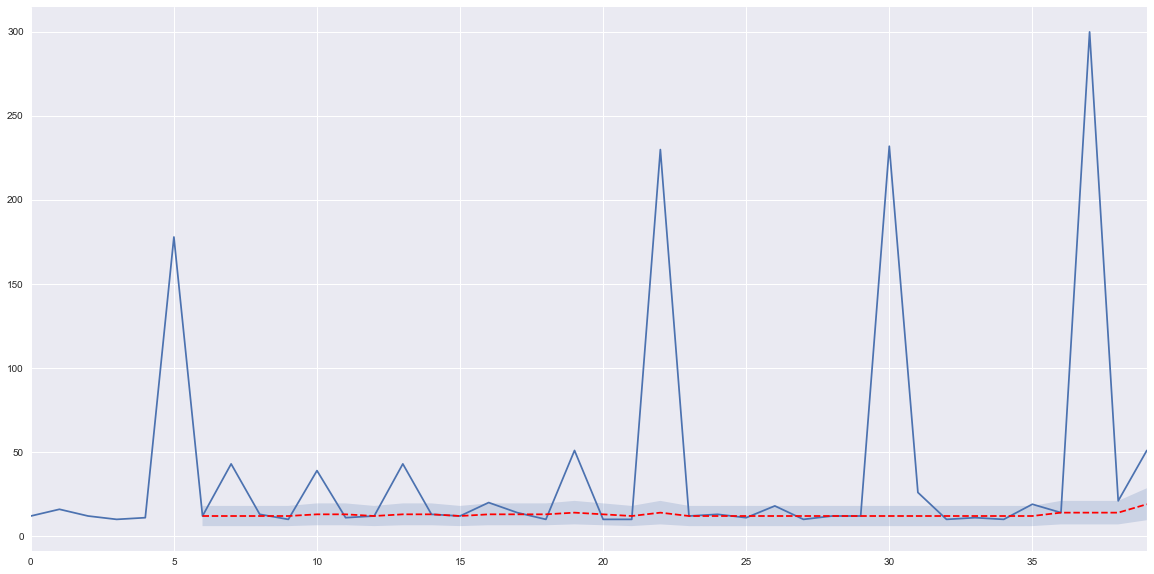

In [28]:
_=vendas.Vendas.plot(figsize=(20, 10))
_=vendas.MedM.plot(figsize=(20, 10), color='red', style='--')
plt.fill_between(vendas.index, vendas.MedM-vendas.ToleranciaMedM, vendas.MedM+vendas.ToleranciaMedM, alpha=0.2)
plt.plot()

### Atenção

Observamos que apesar de continuar baseado no comportamento da série, a mediana está penalizando muito mais os picos de variação.